In [1]:
from __future__ import print_function

import csv
import numpy as np

from model import get_model
from utils import real_to_cdf, preprocess

Using TensorFlow backend.


In [2]:
def load_validation_data():
    """
    Load validation data from .npy files.
    """
    X = np.load('data/X_validate.npy')
    ids = np.load('data/ids_validate.npy')

    X = X.astype(np.float32)
    X /= 255

    return X, ids



In [3]:
def accumulate_study_results(ids, prob):
    """
    Accumulate results per study (because one study has many SAX slices),
    so the averaged CDF for all slices is returned.
    """
    sum_result = {}
    cnt_result = {}
    size = prob.shape[0]
    for i in range(size):
        study_id = ids[i]
        idx = int(study_id)
        if idx not in cnt_result:
            cnt_result[idx] = 0.
            sum_result[idx] = np.zeros((1, prob.shape[1]), dtype=np.float32)
        cnt_result[idx] += 1
        sum_result[idx] += prob[i, :]
    for i in cnt_result.keys():
        sum_result[i][:] /= cnt_result[i]
    return sum_result



In [4]:
print('Loading and compiling models...')
model_systole = get_model()
model_diastole = get_model()

print('Loading models weights...')
model_systole.load_weights('weights_systole_best.hdf5')
model_diastole.load_weights('weights_diastole_best.hdf5')

    # load val losses to use as sigmas for CDF
with open('val_loss.txt', mode='r') as f:
    val_loss_systole = float(f.readline())
    val_loss_diastole = float(f.readline())

print('Loading validation data...')
X, ids = load_validation_data()

print('Pre-processing images...')
X = preprocess(X)

batch_size = 32
print('Predicting on validation data...')
pred_systole = model_systole.predict(X, batch_size=batch_size, verbose=1)
pred_diastole = model_diastole.predict(X, batch_size=batch_size, verbose=1)
# real predictions to CDF
cdf_pred_systole = real_to_cdf(pred_systole, val_loss_systole)
cdf_pred_diastole = real_to_cdf(pred_diastole, val_loss_diastole)
print('Accumulating results...')
sub_systole = accumulate_study_results(ids, cdf_pred_systole)
sub_diastole = accumulate_study_results(ids, cdf_pred_diastole)
# write to submission file

Loading and compiling models...
Loading models weights...
Loading validation data...
Pre-processing images...
30/30 [==============================] - 5s     
Predicting on validation data...
30/30 [==============================] - 2s
Accumulating results...


In [5]:
%matplotlib inline

import matplotlib

In [6]:
from __future__ import division
def isclose(a, b, rel_tol=1e-02, abs_tol=0.0):
    return abs(b-a) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

systole volume is: 110
diastole volume is : 177
ef is : 37.8531073446


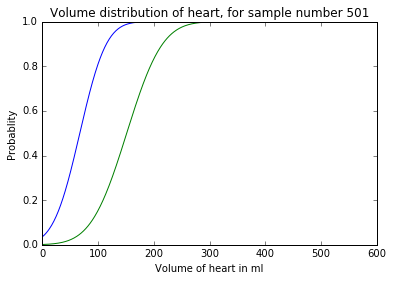

systole volume is: 128
diastole volume is : 212
ef is : 39.6226415094


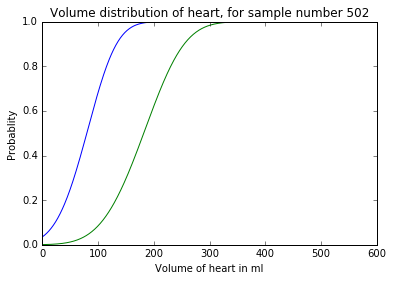

systole volume is: 102
diastole volume is : 197
ef is : 48.2233502538


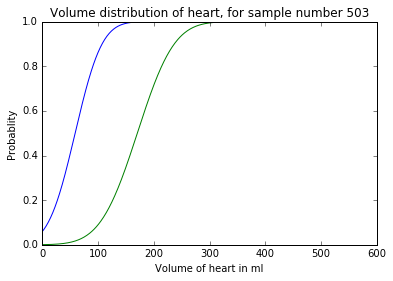

In [7]:
import matplotlib.pyplot as plt
for key in sub_systole:
    idx = 0
    for prob in sub_systole[key][0]:
        if isclose(prob, 0.88):
            print('systole volume is: {0}'.format(idx))
            break
        idx+=1
    vs = idx
    plt.plot(range(0,600),sub_systole[key][0])
    idx = 0
    for prob in sub_diastole[key][0]:
        if isclose(prob, 0.70):
            print('diastole volume is : {0}'.format(idx))
            break
        idx+=1
    vd = idx
    ratio = 0.0
    ratio = ((vd - vs)/vd)*100
    print('ef is : {0}'.format(ratio))
    plt.plot(range(0,600),sub_diastole[key][0])
    plt.ylabel('Probablity')
    plt.xlabel('Volume of heart in ml')
    plt.title('Volume distribution of heart, for sample number {0}'.format(key))
    plt.show()
